In [1]:
from qiskit.quantum_info import Operator, Pauli 
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate
from qiskit import QuantumCircuit, Aer

import numpy as np
from random import choices
from numpy.random import permutation
import matplotlib.pyplot as plt
from itertools import product

The `operator` class has a lot of nice features. This cell sets up some useful operator-related functions.

In [25]:
#convenient names for common operators
I = Operator(np.identity(2))
H = Operator(HGate())
CX = Operator(CXGate())
CZ = Operator(CZGate())
X = Operator(Pauli('X'))
Y = Operator(Pauli('Y'))
Z = Operator(Pauli('Z'))
S = Operator(SGate())
IH = I.tensor(H)
HI = H.tensor(I)

#dimension of the system
n = 2

#iterate through all pauli strings and convert them to operators. indices are a convenient representation of ops
names = ["".join(str) for str in product(['I', 'X', 'Y','Z'], repeat=n)]
paulis = [Operator(Pauli(name)) for name in names]

#match pauli names with operators, so pauli_dict[name] = Operator(Pauli(name))
pauli_dict = dict(zip(names, paulis))

#give this function a pauli matrix and it returns its name if it is on the list, e.g. "XIYZ"
def get_name(pauli_op):
    try:
        #iterate through gates and check if they are equivalent up to global phase
        return names[min([i for (i,gate) in enumerate(paulis) if pauli_op.equiv(gate)])]
    except:
        return -1

#simplifying conjugating a pauli by a clifford
def conjugate(op1, op2):
    return op2.compose(op1).compose(op2.adjoint())

#get a random pauli of a specified weight
def sample_pauli(weight):
    if weight > n:
        return -1
    return pauli_dict["".join(permutation(choices(['X', 'Y','Z'], k=weight)+['I']*(n-weight)))]

In [6]:
from typing import List
import networkx as nx

'''
This class translates an adjacency list of random labels into an adjacency matrix,
and provides some utilities for getting information about the connectivity of the processor.
Uncommented version in processor_connectivity_tools.py
'''
class connectivity_map:

    def __init__(self, undirected_adjacency_list : List[tuple]):

        #For typographical reasons
        ual = undirected_adjacency_list
        #use set so that no two qubits are mapped twice
        qubits_unordered = set()
        #add all qubits from adjacency list to
        for (qubit1,qubit2) in ual:
            qubits_unordered.add(qubit1)
            qubits_unordered.add(qubit2)

        self.num_qubits = len(qubits_unordered)
        self.qubits = range(self.num_qubits) #for iterating
        #this dictionary stores the mapping from internal representation to hardware
        self.mapping = {i:qubit for (i,qubit) in enumerate(qubits_unordered)} #mapping from internal to hardware
        self.reverse_mapping = {v:i for (i,v) in self.mapping.items()} #mapping from hardware to internal
        self.mapped_adjacency_list = undirected_adjacency_list #hardware mapping
        #internal mapping
        self.unmapped_adjacency_list = [(self.reverse_mapping[qubit1], self.reverse_mapping[qubit2]) for (qubit1, qubit2) in ual]
        self.adjacency_matrix = [[] for i in self.qubits] #initialize adjacency matrix
        #change adjacency list to matrix
        for (qubit1,qubit2) in self.unmapped_adjacency_list:
            self.adjacency_matrix[qubit1].append(qubit2)
            self.adjacency_matrix[qubit2].append(qubit1)
    
    #a recursive internal method to find chains. Method has side effects but no return value
    def _get_chain(self, qubit : int, depth : int, prev_chain : List[int], chains : List[tuple]) -> None:
        if depth==0: #add chain as tuple and terminate
            chains.append(tuple(prev_chain)) 
            return

        #create new chain and add each child of current node
        for child in self.adjacency_matrix[qubit]:
            chain = prev_chain.copy() #copy old chain
            if not child in chain: #add child unless there is a loop
                #add child to chain and continue recursively
                chain.append(child)
                self._get_chain(child,depth-1, chain, chains)

    #this method returns all chains of adjacent qubits in the processor
    def get_chains(self, chain_length : int) -> List[tuple]:
        #although it could make sense to use a set, tuples are ordered and sets are unhashable
        chains = []
        #start recursion at every qubit
        for qubit in self.qubits:
            chain = [qubit]
            self._get_chain(qubit, chain_length-1, chain, chains)

        #remove any duplicate chains equal up to permutation
        i = 0
        N = len(chains) #will decrease as chains are removed
        while i < N:
            #log redundant chains for removal
            chains_to_remove = []

            #check all chains greater than i
            for j in range(i+1,N):
                if all(elem in chains[i] for elem in chains[j]): #check if chains are equal up to permutation
                    chains_to_remove.append(chains[j])
            #remove chains
            for j in chains_to_remove:
                chains.remove(j)
            #decrease N to reflect new length of set.
            #i does not need to be decreased becuause only chains > i are checked
            N -= len(chains_to_remove)
            i+=1

        return chains
    
    #This method returns all chains of length depth containing qubit
    def get_chains_with(self, qubit : int, depth : int) -> List[tuple]:
        #create head for recursion
        chains = []
        chain = [qubit]
        #start recursion with current qubit
        self._get_chain(qubit, depth, chain, chains)

        return chains

    #get all qubits that are separated by depth steps from the current qubit
    def connections_at_depth(self, qubit : int, depth : int) -> List[int]:
        #get the chains originating at qubit and return tail of each
        return [connection[-1] for connection in self.get_chains(qubit, depth)]

    #get all pairs of qubits that are separated by depth steps
    def all_connections_at_depth(self, depth : int) -> List[tuple]:
        #get all of the chains of length depth and return first and last elements of each
        return[(chain[0], chain[-1]) for chain in self.get_chains(depth+1)]

    #create a linear processor of a number of qubits
    def linear_proc(num_qubits : int):
        #create edges representing linear connectivity
        edges = [(i, i+1) for i in range(num_qubits-1)]
        return connectivity_map(edges) 

    #create square processor with side length
    def square_proc(side_length : int):
        #linear processor, but connect ends for a cycle
        edges = [(i, i+1) for i in range((side_length-1)*4-1)]+[((side_length-1)*4-1, 0)]
        return connectivity_map(edges)
    
    #use networkx to display processor as graph
    def draw_processor(self) -> None:
        G = nx.Graph()
        G.add_edges_from(self.mapped_adjacency_list)
        nx.draw_networkx(G)
        plt.show()

    #Visualize a full-rank pauli operator applied to the processor
    #useful for verifying the model generation
    def draw_pauli(self, str : str) -> None:
        G = nx.Graph()
        G.add_edges_from(self.mapped_adjacency_list)
        pos = nx.spring_layout(G, seed=3113794652)
        #create alias labels corresponding to paulis
        labels = dict(zip(self.qubits, str))
        nx.draw_networkx(G, labels = labels, node_shape = "d", node_color = "w")
        plt.show()
    
    #return all paulis with support on qubit_group
    def benchmark_paulis(self, qubit_group : tuple) -> List[str]:
        weight = len(qubit_group)
        pauli_list = []
        #iterate through all weight-length combinations of nonidentity paulis
        for str in product(['X','Y','Z'], repeat = weight):
            pauli_str = ['I']*self.num_qubits #initialize all slots to I
            for char,qb in zip(str,qubit_group):
                pauli_str[qb] = char #apply pauli char to qubit qb
            pauli_list.append("".join(pauli_str)) #add pauli string to list

        return pauli_list #return list of pauli strings

    #run benchmark paulis on all chains of a certain weight
    def proc_benchmark_paulis_weight(self, weight : int) -> set:
        return set([pauli for group in self.get_chains(weight) for pauli in self.benchmark_paulis(group)])

    #run proc_benchmark_paulis_weight for all chains up to max_weight
    def proc_benchmark_max_weight(self, max_weight) -> List[str]:
        benchmark_paulis = set()
        for weight in range(1,max_weight+1):
            benchmark_paulis = benchmark_paulis.union(self.proc_benchmark_paulis_weight(weight))
        return list(benchmark_paulis)

[(0, 1, 2), (0, 1, 3), (1, 3, 5), (2, 1, 3), (3, 5, 4), (3, 5, 6), (4, 5, 6)]
[(0, 5), (1, 4), (1, 6), (2, 5)]
[(0, 1, 2), (0, 1, 3)]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


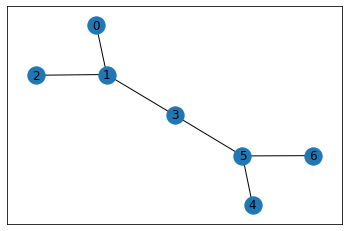

In [13]:
#list copied from IBM spec
nairobi_adjacency = [(0,1),(1,2),(1,3),(3,5),(4,5),(5,6)]
#initialize from adjacency list
nairobi = connectivity_map(nairobi_adjacency)
#print all chains of length 3
print(nairobi.get_chains(3))
#print all qubits separated by 2
print(nairobi.all_connections_at_depth(3))
#print all chains of depth 2 containing qubit 0
print(nairobi.get_chains_with(0,2))
#how the qubits are mapped to the numbers
print(nairobi.mapping)
nairobi.draw_processor()

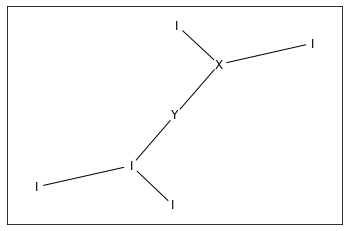

In [14]:
#generate benchmarking group with weight two lining up with the connectivity of the nairobi QPU
pauli_group = nairobi.proc_benchmark_max_weight(2)
#display a random operator drawn over the processor
nairobi.draw_pauli(choices(pauli_group)[0])

In [26]:
#create a small two-qubit model to begin testing
small_proc = connectivity_map.linear_proc(2)
pauli_group = small_proc.proc_benchmark_max_weight(2)
print(pauli_group)

['YZ', 'YI', 'ZI', 'XY', 'ZZ', 'YX', 'IY', 'IZ', 'XI', 'YY', 'XZ', 'XX', 'IX', 'ZY', 'ZX']


In [17]:
PREP_CIRCUITS = {'0Z':I, '1Z':X, '0X':H, '1X':X.compose(H), '0Y':H.compose(S), '1Y':X.compose(H).compose(S)}
MEAS_CIRCUITS = {'Z':I, 'X':H, 'Y':S.compose(H)}
def pauli_eigenstate_prep_ops(pauli_str):
    pos_states = []
    neg_states = []
    dim = len(pauli_str)
    weight = len(pauli_str)-pauli_str.count('I')
    for sgns in product([0,1],repeat=weight):
        op = Operator([1])
        for i in range(dim):
            if pauli_str[i] == 'I':
                op  = op.tensor(I)
            else:
                idx = i-pauli_str[:i].count('I')
                op = op.tensor(PREP_CIRCUITS[str(sgns[idx])+pauli_str[i]])
        if sum(sgns) %2 == 0:
            pos_states.append(op)
        else:
            neg_states.append(op)
    return (pos_states, neg_states)

def measure_in_pauli_basis(pauli_str):
    op = Operator([1])
    for char in pauli_str:
        if char == 'I':
            op = op.tensor(I)
        else:
            op = op.tensor(MEAS_CIRCUITS[char])
    return op

## Measurement procedure

In [18]:
pauli = pauli_group[0]
gate_to_benchmark = CZ
prep_circuits_pos, prep_circuits_neg = pauli_eigenstate_prep_ops('XX')

def count_to_val(count):
    return -2*(count.count('1') % 2)+1

from qiskit.providers.aer.noise import depolarizing_error, NoiseModel
from qiskit import execute

p = .01
num = len(pauli_group)
onequbit_error = depolarizing_error(p, 1)
twoqubit_error = depolarizing_error(p, 2)
error_model = NoiseModel()
error_model.add_all_qubit_quantum_error(onequbit_error, ['id','rz', 'sx', 'u1', 'u2', 'u3'])
error_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])
basis_gates = error_model.basis_gates

def get_expectation(circuit):
    SHOTS = 10000
    backend = Aer.get_backend('qasm_simulator')
    circ = circuit.copy()
    circ.measure_all()
    counts = execute(circ, backend, shots = SHOTS, noise_model = error_model, basis_gates = basis_gates, optimization_level=0).result().get_counts()
    return np.sum([count_to_val(count)*counts[count]/SHOTS for count in counts.keys()])

In [28]:
def s_prod(a,b):
    return {True:0, False:1}[Pauli(a).commutes(Pauli(b))]

M1 = [[s_prod(a,b) for a in pauli_group] for b in pauli_group]
p_group_permuted = [get_name(conjugate(pauli_dict[pauli], gate_to_benchmark)) for pauli in pauli_group]
M2 = [[s_prod(a,b) for a in p_group_permuted] for b in pauli_group]
M = np.add(M1, M2)

In [20]:
def measure_fidelity(pauli, folds):
    dim = len(pauli)
    op_dim = int(np.log2(gate_to_benchmark.dim[0]))
    prep_circuits_pos, prep_circuits_neg = pauli_eigenstate_prep_ops(pauli)
    total = 0
    for circ in prep_circuits_pos:
        qc = QuantumCircuit(dim)
        qc.append(circ,range(dim))
        for i in range(folds):
            qc.append(gate_to_benchmark, range(op_dim))
            qc.append(gate_to_benchmark, range(op_dim))
        qc.append(measure_in_pauli_basis(pauli),range(dim))
        total += get_expectation(qc)
    for circ in prep_circuits_neg:
        qc = QuantumCircuit(dim)
        qc.append(circ,range(dim))
        for i in range(folds):
            qc.append(gate_to_benchmark, range(op_dim))
            qc.append(gate_to_benchmark, range(op_dim))
        qc.append(measure_in_pauli_basis(pauli),range(dim))
        total -= get_expectation(qc)

    return total*1/2**dim

def exp(x,a):
    return np.exp(-a*x)

from scipy.optimize import curve_fit

def fit_fidelity(pauli, max_folds, precision):
    fidelities = []
    for folds in range(0,max_folds,precision):
        fidelities.append(measure_fidelity(pauli, folds))
    fidelities = [fid/fidelities[0] for fid in fidelities]
    xrange = range(0,max_folds*2, precision*2)
    popt, pcov = curve_fit(exp, xrange, fidelities, p0=[.01])
    return popt, fidelities

def progressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    # Displays a nice progress bar
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

def generate_full_fidelity_list(max_folds, precision):
    fidelities = []
    progressBar(0, len(pauli_group))
    for i,pauli in enumerate(pauli_group):
        fidelities.append(fit_fidelity(pauli, max_folds, precision)[0][0])
        progressBar(i+1, len(pauli_group))
    return fidelities

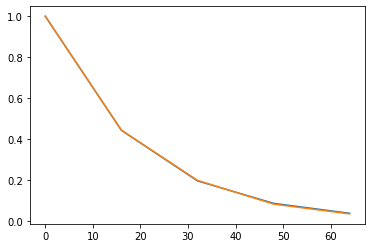

In [22]:
prec = 8
coeffs, fidelities = fit_fidelity("YY", 40, prec)

xrange = range(0,80, prec*2)
plt.plot(xrange, [exp(x,coeffs[0]) for x in xrange])
plt.plot(xrange, fidelities)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


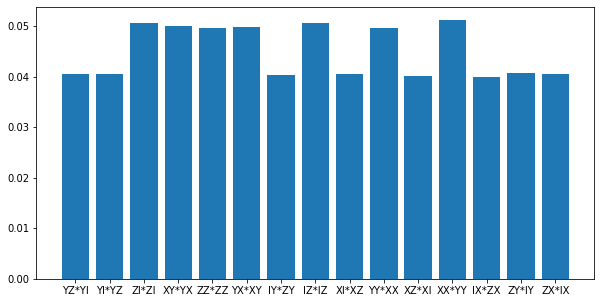

In [40]:
f = generate_full_fidelity_list(40, 8)
fig, ax = plt.subplots()
ax.bar(range(len(pauli_group)), f)
ax.set_xticks(range(len(pauli_group)), [p1+"*"+p2 for p1,p2 in zip(pauli_group, p_group_permuted)]);
fig.set_size_inches(10, 5, forward=True)